<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-data-to-calculations" data-toc-modified-id="Preparing-data-to-calculations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing data to calculations</a></span><ul class="toc-item"><li><span><a href="#Invers-Tier-1-ratio" data-toc-modified-id="Invers-Tier-1-ratio-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Invers Tier 1 ratio</a></span></li><li><span><a href="#Invers-Tier-1-/-Risk-weighted-assets-ratio" data-toc-modified-id="Invers-Tier-1-/-Risk-weighted-assets-ratio-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Invers Tier 1 / Risk weighted assets ratio</a></span></li></ul></li><li><span><a href="#Regression---Forward-beta" data-toc-modified-id="Regression---Forward-beta-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression - Forward beta</a></span><ul class="toc-item"><li><span><a href="#Extra-regression-check" data-toc-modified-id="Extra-regression-check-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extra regression check</a></span></li></ul></li><li><span><a href="#Kernel-regression" data-toc-modified-id="Kernel-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel regression</a></span></li><li><span><a href="#Shorted-time-periode" data-toc-modified-id="Shorted-time-periode-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shorted time periode</a></span><ul class="toc-item"><li><span><a href="#Invers-tier-1-ratio---shorted-time-periode" data-toc-modified-id="Invers-tier-1-ratio---shorted-time-periode-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Invers tier 1 ratio - shorted time periode</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Regression</a></span></li><li><span><a href="#Extra-regression-test" data-toc-modified-id="Extra-regression-test-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Extra regression test</a></span></li></ul></li><li><span><a href="#Theoretic-graph" data-toc-modified-id="Theoretic-graph-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Theoretic graph</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

"""
Load relevant packages 
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pandas_datareader as pdr
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
from scipy.stats import kurtosis
from scipy.stats import skew
from typing import Union, List
import math as m
from sklearn import datasets, linear_model
import statsmodels.api as sm

In [2]:
"""
Set path to get save data
"""
path = "/Users/julielaustsen/Desktop/OneDrive/UNI/Speciale /Data/Eikon"
os.chdir(path) 

In [3]:
"""
Load saved dataframes and dictionareis
"""
with open('data_calc_win', 'rb') as data_dict_win:
    data_calc_win = pickle.load(data_dict_win) 

with open('regress_calc', 'rb') as regress: #load backward beta
    regress_calc = pickle.load(regress)
    
with open('regress_calc_for', 'rb') as regress_for: #load forward beta
    regress_calc_for = pickle.load(regress_for)

## Preparing data to calculations

In [4]:
"""
To get the same columns names in each dataframe
"""
columns_list = ['Market Value', 'Return', 'Excess Return', 'Book Equity', 'Book Leverage ratio', 'Book Equity ratio', 'Book Equity/RWA', 'Tier 1 ratio','Tier 1/RWA','Total Assets','Total Risk Weighted Assets']

for i in data_calc_win.keys():
    data_calc_win[i].columns = columns_list


In [5]:
"""
Collecting all the variables we need into one dictionary
"""

main_dict = {}
main_dict = data_calc_win.copy()

for i in data_calc_win.keys():
    main_dict[i].drop(columns=['Return', 'Excess Return', 'Book Equity', 'Book Leverage ratio'])
    main_dict[i]['Backward beta'] = np.array(regress_calc[i]['Beta'])
    main_dict[i]['Forward beta'] = np.array(regress_calc_for[i]['Beta'])
    main_dict[i]['Invers tier 1 ratio'] = 1 / main_dict[i]['Tier 1 ratio']
    main_dict[i]['Invers tier 1 ratio/RWA'] = 1 / main_dict[i]['Tier 1/RWA']

In [6]:
"""
To remove inf values in the inverse variables
"""

#for invers Tier 1 ratio
for i in main_dict.keys():
    for j in range(len(main_dict[i].index)):
        if m.isinf(main_dict[i].iloc[j,-2])==True:
            main_dict[i].iloc[j,-2] = np.nan
        else:
            pass
        
#for invers tier 1/RWA ratio
for i in main_dict.keys():
    for j in range(len(main_dict[i].index)):
        if m.isinf(main_dict[i].iloc[j,-1])==True:
            main_dict[i].iloc[j,-1] = np.nan
        else:
            pass

In [7]:
"""
We create a dictionary with all the data minus the last 12 rows because we are regressing with forward beta
"""
main_dict_for = {}
main_dict_for = main_dict.copy()

for i in main_dict_for.keys():
    main_dict_for[i].reset_index(inplace=True)
    main_dict_for[i] = main_dict_for[i].drop([264,265,266,267,268,269,270,271,272,273,274,275])

In [8]:
"""
We bring all data together in one dataframe and drop all the columns we shall not use
"""

all_data_for = pd.concat([main_dict_for[i] for i in main_dict_for.keys()])
all_data_for.drop(all_data_for.iloc[:,:13], inplace = True, axis = 1)

In [9]:
#Check no of rows
print(len(main_dict_for.keys())*len(main_dict_for[i]))
print(len(all_data_for))

59664
59664


### Invers Tier 1 ratio

In [10]:
"""
We want the same amount of observations for forward beta and invers tier 1 ratio
"""
all_data_for_nan = all_data_for.copy()
all_data_for_nan = all_data_for_nan[~all_data_for_nan.iloc[:,:2].isna().any(axis=1)] #we remove all the observations where we miss a value

In [11]:
# to check whether we still have nan values in our dataset 
print(np.isnan(all_data_for_nan.iloc[:,1]).sum())
print(np.isnan(all_data_for.iloc[:,1]).sum())
print(np.isnan(all_data_for_nan.iloc[:,0]).sum())
print(np.isnan(all_data_for.iloc[:,0]).sum())

0
27114
0
21577


In [12]:
"""
Invers TIER 1 ratio
First try showed that we have outliers. We therefor remove all the data where invers tier 1 ratio is above 99% quatile
"""
#define outler
outlier = all_data_for_nan['Invers tier 1 ratio'].quantile(0.99)
#remove outliers from data with mask
all_data_for_nan = all_data_for_nan[all_data_for_nan.iloc[:,1] <= outlier]

### Invers Tier 1 / Risk weighted assets ratio

In [13]:
"""
We want the same amount of observations for forward beta and invers tier 1/ RWA ratio
"""
all_data_for_nan_RWA = all_data_for.copy()
all_data_for_nan_RWA = all_data_for_nan_RWA.drop(columns=['Invers tier 1 ratio'])
all_data_for_nan_RWA = all_data_for_nan_RWA[~all_data_for_nan_RWA.iloc[:,:2].isna().any(axis=1)] #we remove all the observations where we miss a value

In [14]:
# to check whether we still have nan values in our dataset 
print(np.isnan(all_data_for_nan_RWA.iloc[:,1]).sum())
print(np.isnan(all_data_for.iloc[:,2]).sum()) # 2 because we have all three variables in this dataframe
print(np.isnan(all_data_for_nan_RWA.iloc[:,0]).sum())
print(np.isnan(all_data_for.iloc[:,0]).sum())

0
31152
0
21577


In [15]:
"""
Invers TIER 1/RWA ratio
First try showed that we have outliers. We therefor remove all the data where invers tier 1/RWA ratio is above 99% quatile
"""
#define outler
outlier = all_data_for_nan_RWA['Invers tier 1 ratio/RWA'].quantile(0.99)
#remove outliers from data with mask
all_data_for_nan_RWA = all_data_for_nan_RWA[all_data_for_nan_RWA.iloc[:,1] <= outlier]

## Regression - Forward beta 

In [16]:
"""
We regress forward beta on Invers tier 1 ratio and store the results in a tabel
"""
descriptive18 = pd.DataFrame()

Y = all_data_for_nan['Forward beta'].astype('float64')
X = all_data_for_nan['Invers tier 1 ratio'].astype('float64').to_numpy().reshape(-1,1)

lm = LinearRegression(fit_intercept=False)
lm.fit(X,Y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
r_squared = lm.score(X,Y)

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,4)
params = np.round(params,4)

descriptive18.loc['Slope', 'Invers tier 1 ratio'] = '{:,.03f}'.format(params[1])
descriptive18.loc['Slope p-value', 'Invers tier 1 ratio'] = '{:,.03f}'.format(p_values[1])


In [17]:
"""
We regress forward beta on Invers tier 1/RWA ratio and store the results in a tabel
"""

Y = all_data_for_nan_RWA['Forward beta'].astype('float64')
X = all_data_for_nan_RWA['Invers tier 1 ratio/RWA'].astype('float64').to_numpy().reshape(-1,1)

lm = LinearRegression(fit_intercept=False)
lm.fit(X,Y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
r_squared = lm.score(X,Y)

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,4)
params = np.round(params,4)

descriptive18.loc['Slope', 'Invers tier 1/RWA ratio'] = '{:,.03f}'.format(params[1])
descriptive18.loc['Slope p-value', 'Invers tier 1/RWA ratio'] = '{:,.03f}'.format(p_values[1])


In [18]:
descriptive18.loc['Observations', 'Invers tier 1/RWA ratio'] = '{:,.0f}'.format(len(all_data_for_nan_RWA['Invers tier 1 ratio/RWA']))
descriptive18.loc['Observations', 'Invers tier 1 ratio'] = '{:,.0f}'.format(len(all_data_for_nan['Invers tier 1 ratio']))
descriptive18

,Invers tier 1 ratio,Invers tier 1/RWA ratio
Slope,0.046,0.096
Slope p-value,0.000,0.000
Observations,"30,389","26,554"


### Extra regression check

In [19]:
"""
We perform an extra OLS regression to double check our results and to save R2
"""
Y = all_data_for_nan['Forward beta'].iloc[:-12].tolist()
X = all_data_for_nan['Invers tier 1 ratio'].iloc[:-12].tolist() 
#X2 = sm.add_constant(X)
result = sm.OLS(Y, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.540
Model:                            OLS   Adj. R-squared (uncentered):              0.540
Method:                 Least Squares   F-statistic:                          3.567e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        19:46:23   Log-Likelihood:                         -37553.
No. Observations:               30377   AIC:                                  7.511e+04
Df Residuals:                   30376   BIC:                                  7.512e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [20]:
descriptive18.loc['R-squared', 'Invers tier 1 ratio'] = '{:,.03f}'.format(result.rsquared) #Save the R2 in the tabel

In [21]:
y_pred = result.predict(np.arange(1, 40)) #we save the predictions for the graph later

In [22]:
slope = result.params[0] #we save the slope for the graph

In [23]:
"""
Linear regression on forward beta and invers tier 1 ratio/RWA
"""
Y = all_data_for_nan_RWA['Forward beta'].iloc[:-12].tolist()
X = all_data_for_nan_RWA['Invers tier 1 ratio/RWA'].iloc[:-12].tolist() 
X2 = sm.add_constant(X)
result = sm.OLS(Y, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.513
Model:                            OLS   Adj. R-squared (uncentered):              0.513
Method:                 Least Squares   F-statistic:                          2.792e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        19:46:24   Log-Likelihood:                         -34573.
No. Observations:               26542   AIC:                                  6.915e+04
Df Residuals:                   26541   BIC:                                  6.916e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
descriptive18.loc['R-squared', 'Invers tier 1/RWA ratio'] = '{:,.03f}'.format(result.rsquared)#Save the R2 in the tabel

## Kernel regression
Important it is necessary to run section 1 and 2 before running this section 

In [25]:
'''Class for Epanechnikov Kernel Regression'''
class EKR:
    
    def __init__(self, x, y, b):
        self.x = np.array(x)
        self.y = np.array(y)
        self.b = b
        
    '''Implement the Epanechnikov Kernel'''
    def epanechnikov_kernel(self, z):
        if np.linalg.norm(z) > 1:
            return 0
        else:
            return (0.75*(1-np.power(z,2)))
    
    '''Calculate weights and return prediction'''
    def predict(self, X):
            kernels = np.array([self.epanechnikov_kernel((np.linalg.norm(xi-X))/self.b) for xi in self.x])
            weights = np.array([(kernel/np.sum(kernels)) for kernel in kernels])
            return np.dot(weights.T, self.y)

In [26]:
"""
Applying Epanechnikov Kernel Regression on data
"""

x = all_data_for_nan.iloc[:,1] #x variable 
y = all_data_for_nan.iloc[:,0] #y variable
b = 2 #smoothing interval

KR = EKR(x=x, y=y, b=b)

pred = [KR.predict(xi) for xi in np.arange(1, 40)]

In [27]:
"""
We create an numpy array with our linear predicted values in order to plot the linear relationship between forward beta and tier 1 ratio
"""
x1 = np.arange(1, 40)
y1 = y_pred
lin_plot = np.stack((x1, y1), axis=1)

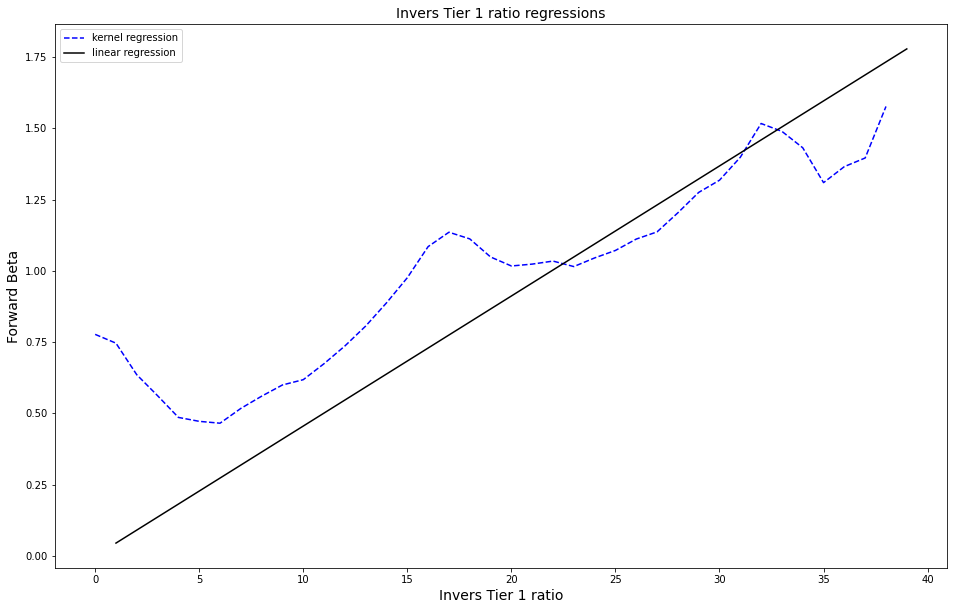

In [28]:
"""
Plotting the results
"""
fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.plot(np.arange(39), pred, color='blue', label='kernel regression', linestyle='--')
ax.plot(lin_plot[:,0], lin_plot[:,1], color='black', label='linear regression')
ax.set_ylabel('Forward Beta').set_fontsize(14)
ax.set_xlabel('Invers Tier 1 ratio').set_fontsize(14)
ax.set_title('Invers Tier 1 ratio regressions').set_fontsize(14)
ax.legend();

## Shorted time periode

In [29]:
"""
We create a dictionary with all the values but we short the time periode to be equvialent to Baker and Wurgler
"""

shorted_data = {}

for i in main_dict_for.keys():
    shorted_data[i] = main_dict_for[i].copy()
    shorted_data[i].drop(inplace = True, axis =0, labels=range(144,264)) #number 144 is included in the data still. It is equivalent to 2010-12-24
    

In [30]:
"""
We bring all data together in one dataframe and drop all the columns we shall not use
"""

shorted_data_for = pd.concat([shorted_data[i] for i in shorted_data.keys()])
shorted_data_for.drop(shorted_data_for.iloc[:,:13], inplace = True, axis = 1)

In [31]:
#Check no of rows
print(len(shorted_data.keys())*len(shorted_data[i]))
print(len(shorted_data_for))

32544
32544


### Invers tier 1 ratio - shorted time periode

In [32]:
"""
We want the same amount of observations for forward beta and invers tier 1 ratio
"""
shorted_data_for_nan = shorted_data_for.copy()
shorted_data_for_nan = shorted_data_for_nan[~shorted_data_for_nan.iloc[:,:2].isna().any(axis=1)] #we remove all the observations where we miss a value

In [33]:
# to check whether we still have nan values in our dataset 
print(np.isnan(shorted_data_for_nan['Invers tier 1 ratio']).sum())
print(np.isnan(shorted_data_for_nan['Forward beta']).sum())

0
0


In [34]:
"""
Invers TIER 1 ratio
We use the same outlier value as with the Invers Tier 1 ratio calculation with full dataset 
"""
#define outler
outlier = all_data_for['Invers tier 1 ratio'].quantile(0.99)
#remove outliers from data with mask
shorted_data_for_nan = shorted_data_for_nan[shorted_data_for_nan.iloc[:,1] <= outlier]

### Regression

In [35]:
"""
We regress forward beta on Invers tier 1 ratio and store the results in a tabel (SHORTED TIME PERIOD)
"""

Y = shorted_data_for_nan['Forward beta'].astype('float64')
X = shorted_data_for_nan['Invers tier 1 ratio'].astype('float64').to_numpy().reshape(-1,1)

lm = LinearRegression(fit_intercept=False)
lm.fit(X,Y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
r_squared = lm.score(X,Y)

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,4)
params = np.round(params,4)

descriptive18.loc['Slope', 'Invers tier 1 ratio (shorted time period)'] = '{:,.03f}'.format(params[1])
descriptive18.loc['Slope p-value', 'Invers tier 1 ratio (shorted time period)'] = '{:,.03f}'.format(p_values[1])

In [36]:
"""
We add numbers of observations and print the tabel
"""
descriptive18.loc['Observations', 'Invers tier 1 ratio (shorted time period)'] = '{:,.0f}'.format(len(shorted_data_for_nan['Invers tier 1 ratio']))


### Extra regression test

In [37]:
"""
We perform an extra OLS regression to double check our results and to save R2
"""
Y = shorted_data_for_nan['Forward beta'].iloc[:-12].tolist()
X = shorted_data_for_nan['Invers tier 1 ratio'].iloc[:-12].tolist() 
#X2 = sm.add_constant(X)
result = sm.OLS(Y, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.563
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                          2.165e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        19:46:55   Log-Likelihood:                         -19001.
No. Observations:               16822   AIC:                                  3.800e+04
Df Residuals:                   16821   BIC:                                  3.801e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [38]:
"""
The final results for step 1 (asset beta)
"""

descriptive18.loc['R-squared', 'Invers tier 1 ratio (shorted time period)'] = '{:,.03f}'.format(result.rsquared)
descriptive18

,Invers tier 1 ratio,Invers tier 1/RWA ratio,Invers tier 1 ratio (shorted time period)
Slope,0.046,0.096,0.040
Slope p-value,0.000,0.000,0.000
Observations,"30,389","26,554","16,834"
R-squared,0.540,0.513,0.563


## Theoretic graph

Text(34, 1.5, '$true \\beta_a$')

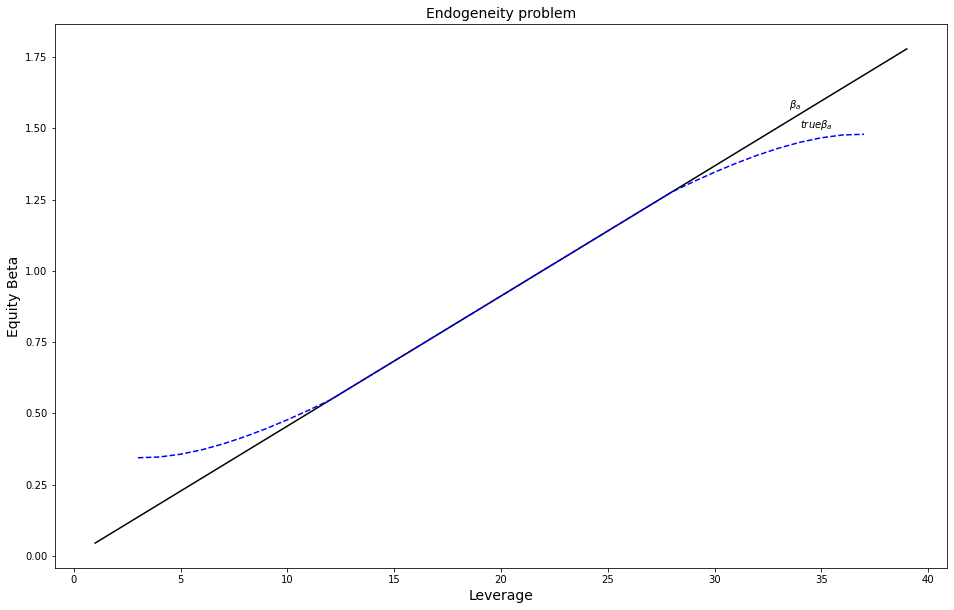

In [40]:
"""
Plotting the theoretical graph
"""
theory = [0.34477411,0.347370972,0.357134195,0.372869386,0.393581216,0.418440247,0.446755278,0.477950309,0.51154534,
0.547140371,0.592735402,0.638330433,0.683925464,0.729520495,0.775115526,0.820710557,0.866305587,0.911900618,0.957495649,
1.00309068,1.048685711,1.094280742,1.139875773,1.185470804,1.231065835,1.276660866,1.312255897,1.345850928,1.377045959,1.405360989,
1.43022002,1.450931851,1.466667042,1.476430265,1.479027126]

fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.plot(lin_plot[:,0], lin_plot[:,1], color='black')
ax.plot(np.arange(3,38,1), theory, color='blue', linestyle='--')
#ax.plot(lin_plot[:,0],lin_plot2[:,1], color='red', linestyle='-.')
ax.set_ylabel('Equity Beta').set_fontsize(14)
ax.set_xlabel('Leverage').set_fontsize(14)
ax.set_title('Endogeneity problem').set_fontsize(14)
#ax.text(33.5,1.25,r'$\widehat{\beta_a}$')
ax.text(33.5,1.57,r'$\beta_a$')
ax.text(34,1.5,r'$true \beta_a$')